In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import chain
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from PIL import Image

In [3]:
df = pd.read_csv('Dataset',sep='\t',header=None)
df.columns = ['Label','SMS']
print(df.shape)
df.head(5)

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


ham     0.865937
spam    0.134063
Name: Label, dtype: float64

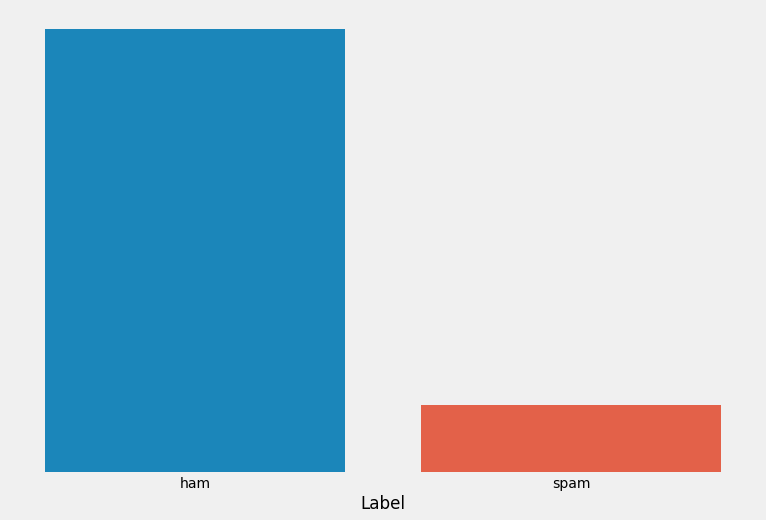

In [4]:
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')
sns.countplot(df.Label)
plt.ylabel('')
plt.yticks([])
df.Label.value_counts(normalize=True)

In [6]:
randomized = df.sample(frac=1,random_state=1)
train_size = round(len(randomized) * 0.8)
train = randomized[:train_size].reset_index(drop=True)
test = randomized[train_size:].reset_index(drop=True)
print(train.shape)
print(test.shape)

(4458, 2)
(1114, 2)


In [7]:
train.Label.value_counts(normalize=True)

ham     0.86541
spam    0.13459
Name: Label, dtype: float64

In [8]:
test.Label.value_counts(normalize=True)

ham     0.868043
spam    0.131957
Name: Label, dtype: float64

In [9]:
train.SMS.head(10)

0                         Yep, by the pretty sculpture
1        Yes, princess. Are you going to make me moan?
2                           Welp apparently he retired
3                                              Havent.
4    I forgot 2 ask ü all smth.. There's a card on ...
5    Ok i thk i got it. Then u wan me 2 come now or...
6    I want kfc its Tuesday. Only buy 2 meals ONLY ...
7                           No dear i was sleeping :-P
8                            Ok pa. Nothing problem:-)
9                      Ill be there on  &lt;#&gt;  ok.
Name: SMS, dtype: object

In [10]:
train.SMS = train['SMS'].str.replace('\W',' ')
train.SMS = train['SMS'].str.lower()
train.SMS.head(10)

0                         yep  by the pretty sculpture
1        yes  princess  are you going to make me moan 
2                           welp apparently he retired
3                                              havent 
4    i forgot 2 ask ü all smth   there s a card on ...
5    ok i thk i got it  then u wan me 2 come now or...
6    i want kfc its tuesday  only buy 2 meals only ...
7                           no dear i was sleeping   p
8                            ok pa  nothing problem   
9                      ill be there on   lt   gt   ok 
Name: SMS, dtype: object

In [11]:
messages = train.SMS.str.split()
words = list(chain(*messages))
vocabulary = pd.Series(words).unique()
len(vocabulary)

7783

In [12]:
no_of_messages = len(train.SMS)
word_counts = {word: [0] * no_of_messages for word in vocabulary}

for index,mssge in enumerate(messages):
    for word in mssge:
        word_counts[word][index] += 1

In [13]:
token = RegexpTokenizer(r'[a-z0-9A-Z]+')
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1,1),
    tokenizer = token.tokenize
)
counts = vectorizer.fit_transform(train['SMS'])
print(len(vectorizer.get_feature_names()))
vocabulary = vectorizer.get_feature_names()

word_counts = dict(zip(vectorizer.get_feature_names(),np.transpose(counts.toarray())))

7508


In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

(-0.5, 1199.5, 799.5, -0.5)

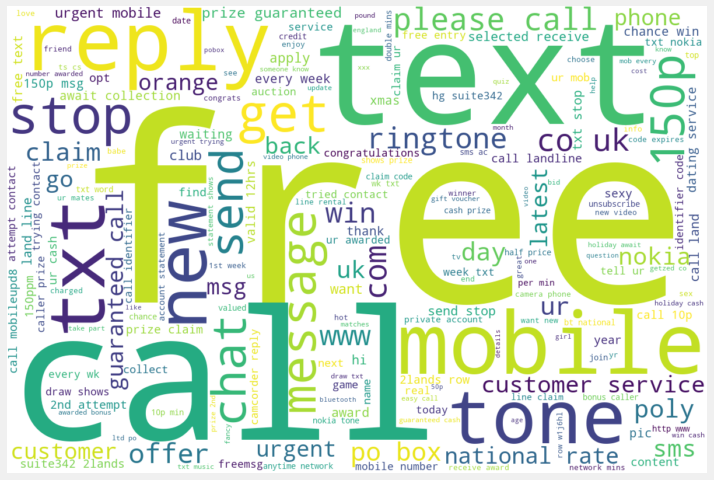

In [16]:
text = ""

for message in train[train.Label == 'spam'].SMS:
    words = message.split()
    text = text + " ".join(words) + " "
    
# stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=800,stopwords=stopwords.words('english'),background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

(-0.5, 1199.5, 799.5, -0.5)

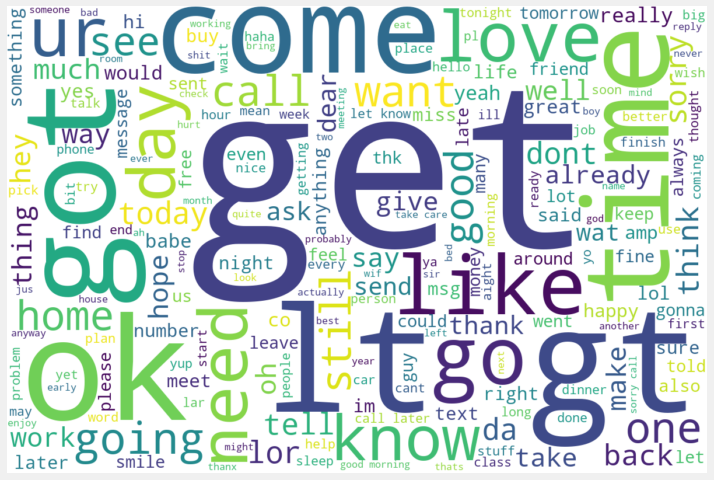

In [17]:
text = ""

for message in train[train.Label == 'ham'].SMS:
    words = message.split()
    text = text + " ".join(words) + " "
    
# stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=800,stopwords=stopwords.words('english'),background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

In [18]:
vector_space = pd.DataFrame(word_counts)
train = pd.concat([train,vector_space],axis=1)
train.head(3)

,Label,SMS,0,00,000,000pes,008704050406,0089,01223585334,02,0207,02072069400,02073162414,02085076972,021,03,04,0430,05,050703,0578,06,07008009200,07046744435,07090201529,07090298926,07099833605,07123456789,0721072,07734396839,07742676969,07753741225,07781482378,07786200117,077xxx,078,07801543489,07808726822,07815296484,07821230901,...,yogasana,yor,yorge,youdoing,youi,young,younger,youphone,youre,yourinclusive,yourjob,youuuuu,youwanna,yoville,yowifes,yoyyooo,yr,yrs,ystrday,ything,yummy,yun,yunny,yuo,yuou,yup,yupz,z,zac,zaher,zealand,zebra,zed,zeros,zhong,zindgi,zoe,zogtorius,zouk,zyada
0,ham,yep by the pretty sculpture,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ham,yes princess are you going to make me moan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ham,welp apparently he retired,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
alpha = 1
P_spam = train.Label.value_counts(normalize=True)['spam']
P_ham = train.Label.value_counts(normalize=True)['ham']
N_spam = len(list(chain(*messages[train.Label == 'spam'])))
N_ham = len(list(chain(*messages[train.Label == 'ham'])))
N_vocab = len(vocabulary)

In [21]:
P_word_given_spam = {word: 0 for word in vocabulary}
P_word_given_ham = {word: 0 for word in vocabulary}

Spam_messages = train[train.Label == 'spam']
Ham_messages = train[train.Label == 'ham']

for word in vocabulary:
    
    N_word_given_spam = Spam_messages[word].sum()
    N_word_given_ham = Ham_messages[word].sum()
    
    P_word_given_spam[word] = (
        (N_word_given_spam + alpha) / (N_spam + (alpha * N_vocab))
    )
    
    P_word_given_ham[word] = (
        (N_word_given_ham + alpha) / (N_ham + (alpha * N_vocab))
    )

In [22]:
def classify(message,verbose):
    
    message = re.sub('\W',' ',message)
    message = message.lower()
    message = message.split()
    
    spam = 1
    ham = 1
    
    for word in message:
        if word in P_word_given_spam.keys():
            spam *= P_word_given_spam[word]
        if word in P_word_given_ham.keys():
            ham *= P_word_given_ham[word]
        
    P_spam_given_message = P_spam * spam
    P_ham_given_message = P_ham * ham
    
    if verbose:
        print("P(spam|message) = ",P_spam_given_message)
        print("P(ham|message) = ",P_ham_given_message)
    
    if P_spam_given_message > P_ham_given_message:
        if verbose:
            print('Label: spam')
        return 'spam'
    elif P_spam_given_message < P_ham_given_message:
        if verbose:
            print('Label: ham')    
        return 'ham'
    else:
        if verbose:
            print('Human assistance needed, equal probabilities')
        return 'Not classified'



In [23]:
classify('WINNER!! This is the secret code to unlock the money: C3421.',verbose=1)

P(spam|message) =  6.814909426971065e-15
P(ham|message) =  1.772963190712378e-17
Label: spam


'spam'

In [24]:
classify('Sounds good, Tom, then see u there',verbose=1)

P(spam|message) =  1.5820325455468539e-15
P(ham|message) =  2.7059850698247674e-13
Label: ham


'ham'

In [25]:
test['predicted'] = test.SMS.apply(classify,verbose=0) #try putting verbose >1 and see the output of the model
test.head(5)

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [26]:
test.predicted.value_counts(normalize=True)

ham     0.857271
spam    0.142729
Name: predicted, dtype: float64

In [27]:
accuracy = sum(test.Label == test.predicted)/len(test)
accuracy

0.9802513464991023

In [28]:
train['predicted'] = train.SMS.apply(classify,verbose=0)
accuracy = sum(train.Label == train.predicted)/len(train)
accuracy

0.9894571556751907

In [29]:
train.predicted.value_counts(normalize=True)

ham     0.856662
spam    0.143338
Name: predicted, dtype: float64

In [30]:
print(classification_report(test.predicted,test.Label))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       955
        spam       0.97      0.89      0.93       159

    accuracy                           0.98      1114
   macro avg       0.97      0.94      0.96      1114
weighted avg       0.98      0.98      0.98      1114



In [31]:
def clean(message):
    
    message = re.sub('\W',' ',message)
    message = message.lower()
    
    return message

test.SMS = test.SMS.apply(clean)
missclassified = test[test.Label != test.predicted]
missclassified

,Label,SMS,predicted
9,ham,i liked the new mobile,spam
18,ham,and picking them up from various points,spam
114,spam,not heard from u4 a while call me now am here...,ham
130,ham,how was txting and driving,spam
131,ham,they have a thread on the wishlist section of ...,spam
152,ham,unlimited texts limited minutes,spam
159,ham,26th of july,spam
284,ham,nokia phone is lovly,spam
302,ham,no calls messages missed calls,spam
313,ham,speaking of does he have any cash yet,spam


(-0.5, 1199.5, 799.5, -0.5)

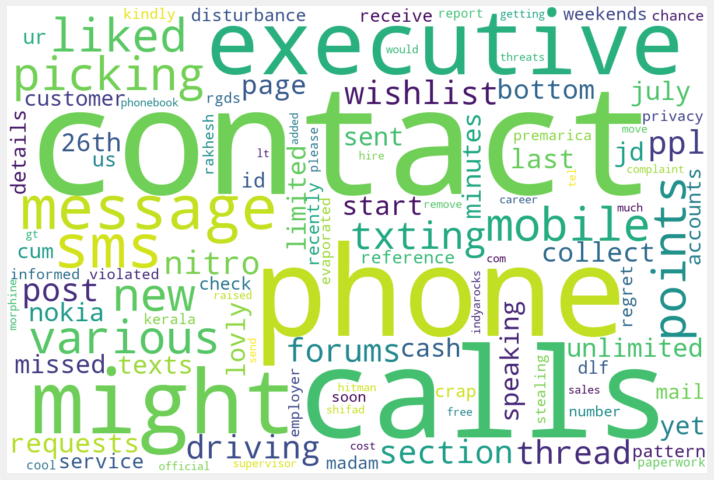

In [32]:
text = ""

for message in missclassified[missclassified.Label == 'ham'].SMS:
    words = message.split()
    text = text + " ".join(words) + " "
    
# stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=800,stopwords=stopwords.words('english'),background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

(-0.5, 1199.5, 799.5, -0.5)

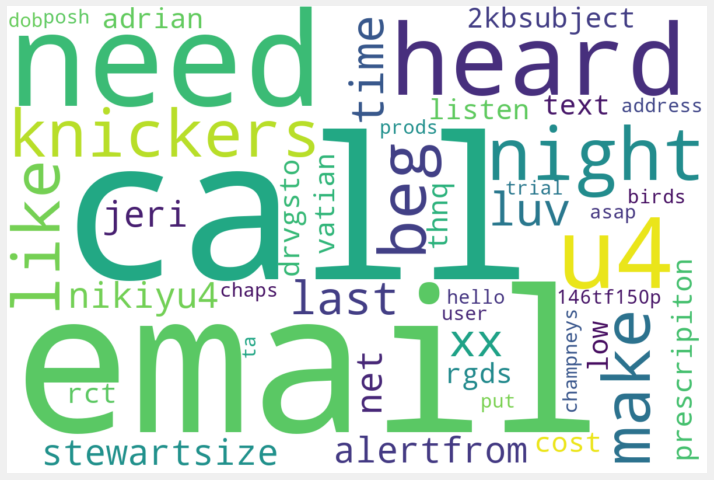

In [33]:
text = ""

for message in missclassified[missclassified.Label == 'spam'].SMS:
    words = message.split()
    text = text + " ".join(words) + " "
    
# stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=800,stopwords=stopwords.words('english'),background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

In conclusion to the project, a successful model for spam filter was created using the Naive Bayes Algorithm. The model assumes independence between the messages and the words in the messages, oblivious to the context of the message.<br>
Just based on this assumption, the model performed very well for this dataset with the following accuracies (approx) :-

* Training accuracy - 98.94%
* Testing accuracy - 98.02%

The model achieves a good precision and recall scores. However it is important to note that *spam* messages have a lesser recall. This can be accounted to the fact that there is an imbalance in the classes of the target variable.

Overall the model has learnt the training data well and has performed well on the test set for the text messages in the dataset used.